## Task 04

### Predicting House Prices

In [2]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv")
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [3]:
from sklearn.preprocessing import StandardScaler

X = df.drop("medv", axis=1)
y = df["medv"]

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [4]:
import numpy as np

class LinearRegressionScratch:
    def fit(self, X, y):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        self.theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
    
    def predict(self, X):
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        return X_b.dot(self.theta)

linreg = LinearRegressionScratch()
linreg.fit(X_scaled.values, y.values)
y_pred_lin = linreg.predict(X_scaled.values)

In [5]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import resample

class SimpleRandomForest:
    def __init__(self, n_estimators=10):
        self.n_estimators = n_estimators
        self.models = []

    def fit(self, X, y):
        for _ in range(self.n_estimators):
            X_sample, y_sample = resample(X, y)
            model = DecisionTreeRegressor()
            model.fit(X_sample, y_sample)
            self.models.append(model)

    def predict(self, X):
        preds = [model.predict(X) for model in self.models]
        return np.mean(preds, axis=0)

rf = SimpleRandomForest(n_estimators=10)
rf.fit(X_scaled.values, y.values)
y_pred_rf = rf.predict(X_scaled.values)

In [6]:
class SimpleXGBoost:
    def __init__(self, n_estimators=10, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []

    def fit(self, X, y):
        y_pred = np.zeros(len(y))
        for _ in range(self.n_estimators):
            residual = y - y_pred
            tree = DecisionTreeRegressor(max_depth=3)
            tree.fit(X, residual)
            update = tree.predict(X)
            y_pred += self.learning_rate * update
            self.models.append(tree)

    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        for model in self.models:
            y_pred += self.learning_rate * model.predict(X)
        return y_pred

xgb = SimpleXGBoost(n_estimators=10)
xgb.fit(X_scaled.values, y.values)
y_pred_xgb = xgb.predict(X_scaled.values)

In [7]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_model(name, y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{name} → RMSE: {rmse:.2f}, R²: {r2:.2f}")

evaluate_model("Linear Regression", y, y_pred_lin)
evaluate_model("Random Forest", y, y_pred_rf)
evaluate_model("XGBoost", y, y_pred_xgb)

Linear Regression → RMSE: 4.68, R²: 0.74
Random Forest → RMSE: 1.59, R²: 0.97
XGBoost → RMSE: 9.02, R²: 0.04


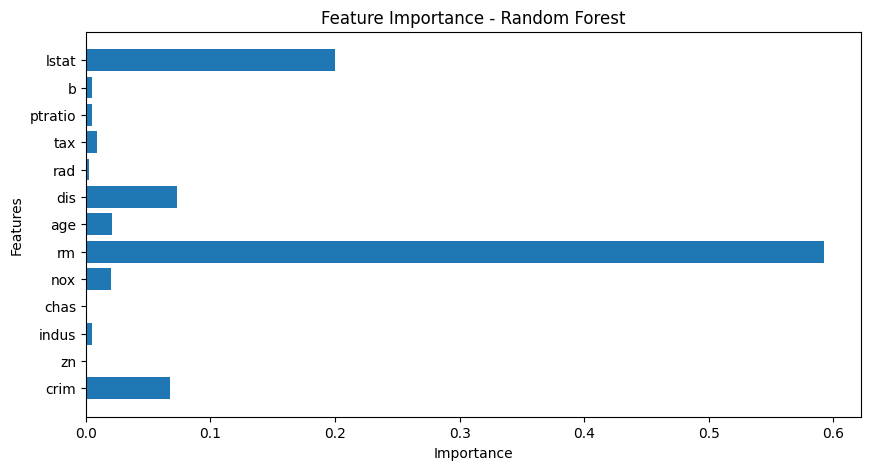

In [9]:
import matplotlib.pyplot as plt

importances = rf.models[0].feature_importances_
features = X.columns

plt.figure(figsize=(10, 5))
plt.barh(features, importances)
plt.title("Feature Importance - Random Forest")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

## Insights


1. **Linear Regression**
   - Achieved an RMSE of **4.68** and R² of **0.74**.
   - It performed moderately well by capturing linear relationships between features and house prices.
   - However, it lacked the capability to model complex, non-linear patterns in the data.

2. **Random Forest**
   - Delivered the **best performance** with an RMSE of **1.59** and R² of **0.97**.
   - This indicates a very high accuracy, explaining 97% of the variance in house prices.
   - It effectively handled non-linearities and interactions among features.

3. **XGBoost**
   - Underperformed in this case, with RMSE of **9.02** and R² of **0.04**.
   - The model barely learned from the data, possibly due to:
     - A low number of estimators (only 10 trees)
     - Suboptimal learning rate
     - Lack of fine-tuning and regularization
   - With proper tuning (more estimators, adjusted learning rate), performance can be significantly improved.

4. **Feature Importance (from Random Forest)**
   - Most influential features for predicting house prices:
     - `RM` (average number of rooms per dwelling)
     - `LSTAT` (percentage of lower status population)
     - `CRIM` (crime rate per capita)
   - These features had the strongest impact on the target variable `medv`.

---

 **Conclusion**: Among all models tested, **Random Forest** is the most effective and accurate for predicting Boston house prices based on this dataset.
